In [36]:
version_num = "09"

In [37]:
import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display
import pypianoroll
from music_theory_utils import make_dicts,inversion
import datetime

In [38]:
key2array_dicts,chord2array_dicts = make_dicts()
chord2array_dicts = {key:inversion(np.array(val),course=48) for key,val in chord2array_dicts.items() }

In [39]:
chord2array_dicts

{'Cm6addb9': array([48, 51, 55, 57, 49]),
 'Cm6add9': array([48, 51, 55, 57, 50]),
 'Cm6add#9': array([48, 51, 55, 57, 51]),
 'Cm6add#11': array([48, 51, 55, 57, 54]),
 'Cm6addb13': array([48, 51, 55, 57, 56]),
 'Cm6': array([48, 51, 55, 57]),
 'Cm7addb9': array([48, 51, 55, 58, 49]),
 'Cm7add9': array([48, 51, 55, 58, 50]),
 'Cm7add#9': array([48, 51, 55, 58, 51]),
 'Cm7add#11': array([48, 51, 55, 58, 54]),
 'Cm7addb13': array([48, 51, 55, 58, 56]),
 'Cm7': array([48, 51, 55, 58]),
 'Cmmaj7addb9': array([48, 51, 55, 59, 49]),
 'Cmmaj7add9': array([48, 51, 55, 59, 50]),
 'Cmmaj7add#9': array([48, 51, 55, 59, 51]),
 'Cmmaj7add#11': array([48, 51, 55, 59, 54]),
 'Cmmaj7addb13': array([48, 51, 55, 59, 56]),
 'Cmmaj7': array([48, 51, 55, 59]),
 'Cmaddb9': array([48, 51, 55, 49]),
 'Cmadd9': array([48, 51, 55, 50]),
 'Cmadd#9': array([48, 51, 55, 51]),
 'Cmadd#11': array([48, 51, 55, 54]),
 'Cmaddb13': array([48, 51, 55, 56]),
 'Cm': array([48, 51, 55]),
 'Cm6b5addb9': array([48, 51, 54, 57

In [40]:
quaver_tri_reso  = 1
quaver_reso      = quaver_tri_reso * 3 #8部音符の解像度
quarter_tri_reso = quaver_tri_reso * 2 
quarter_reso     = quarter_tri_reso * 3  # 4部音符の解像度 
bar_reso         = quarter_reso * 4 # 1小節の解像度　　一小節の分解能は96で良いのでは？
bar_num          = 8     # 小節数
all_reso         = bar_num * bar_reso # 8 * 24
tempo            = 120    #bpm

pitch_reso = 128    # 鍵盤の数
note_velocity = 127

tempos = tempo*np.ones( [all_reso,1] )

note2long_dicts = {"quarter":quarter_reso,         
                   "quaver":quaver_reso,           
                   "quaver_tri":quaver_tri_reso,   
                   "quarter_tri":quarter_tri_reso}

long2note_dicts = {val:key for key, val in note2long_dicts.items()}

### ここから★

In [129]:
multitrack   = pypianoroll.Multitrack(resolution=quarter_reso,tempo=tempos)

### make chord track

In [130]:
track1 = pypianoroll.StandardTrack(name="piano",program=0,is_drum=False)
multitrack.tracks.append(track1)

In [131]:
chords = ["C","G","Am7","Em7","F","C","Fadd9","G7"]

描画

In [132]:
pianoroll = np.zeros( [all_reso,pitch_reso] ,dtype=np.uint8)
for bar in range(8):
    start =   bar * bar_reso
    end   = ( bar+1 )*bar_reso
    
    chord = chord2array_dicts[chords[bar]]
    pianoroll[start:end,chord] = 127
    pianoroll[start:end,chord[0] - 12] = 127 # ベース音の追加

track1.pianoroll = pianoroll

[<AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>]

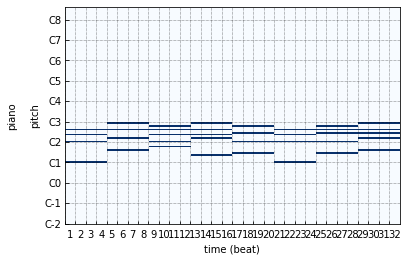

In [133]:
#plt.figure()
multitrack.plot()

### make melody track

####  make motif

In [134]:
#8部(20%) 4部(60%) or ４部休符(10%) or 8部休符(10%)

In [135]:
def make_motief_rhythm():
    events_choice = {"quarter_note":0.6,"quaver_note":0.3,"quarter_rest":0.05,"quaver_rest":0.05}
    
    rhythm_list = []
    note_dulation_sum = 0
    
    while bar_reso > note_dulation_sum:
        # 
        note_char = np.random.choice(list( events_choice.keys()) ,p=list(events_choice.values()),replace=True)
        long, switch = note_char.split("_")
        note_dulation = note2long_dicts[long]
        note_dulation_sum += note_dulation

        rhythm_list.append(note_char)
    
    if note_dulation_sum > bar_reso:
        diff_dulation = note_dulation_sum - bar_reso
        rhythm_list[-1] = long2note_dicts[diff_dulation] + "_" + switch
    
    return rhythm_list

In [136]:
def make_motief_pitch(rhythm_list):
    pentas_keys  = ["C","D","E","G","A"]
    octave_nums  = ["4","5"]
    pentas_choice = {i+j:1/(len(pentas_keys)*len(octave_nums)) for i in pentas_keys for j in octave_nums}
    pitch_list = []
    for rhythm in rhythm_list:
        [long, switch] = rhythm.split("_")
        
        if switch == "rest":
            melo = "null"
        else:
            melo  = np.random.choice( list(pentas_choice.keys()),p=list(pentas_choice.values()),replace=True)
        
        pitch_list.append(melo)
    
    return pitch_list

In [137]:
def events2pianoroll(rhythm_list, pitch_list):
    bar_pianoroll = np.zeros([bar_reso,pitch_reso])
    note_start = 0
    note_end = 0
    note_list = [note.split("_")[0] for note in rhythm_list]
    for note, melo in zip(note_list, pitch_list):
        note_dulation = note2long_dicts[note]
        note_end = note_start + note_dulation
        if melo != "null":
            pitch = key2array_dicts[melo]
            bar_pianoroll[note_start:note_end,pitch] = note_velocity
        note_start = note_end
    return bar_pianoroll

In [138]:
def make_motief():
    rhythm_list = make_motief_rhythm()
    pitch_list = make_motief_pitch(rhythm_list)
    pianoroll = events2pianoroll(rhythm_list, pitch_list)
    return rhythm_list, pitch_list, pianoroll

### モチーフ反復

In [139]:
#1小節目生成
bar_rhythm_list = []
bar_pitch_list = []
bar_pianoroll_list = []
bar_rhythm_list.append(make_motief_rhythm())
bar_pitch_list.append(make_motief_pitch(bar_rhythm_list[0]))
bar_pianoroll_list.append(events2pianoroll(bar_rhythm_list[0], bar_pitch_list[0]))

for i in [1, 2]:
    if np.random.choice([0, 1], p=[0.5, 0.5]):
        print("コピー")
        # モチーフ反復
        bar_rhythm_list.append(bar_rhythm_list[0])
        bar_pitch_list.append(bar_pitch_list[0])
        bar_pianoroll_list.append(bar_pianoroll_list[0])
    else:
        print("振りなおし")
        # ピッチを振りなおす
        bar_rhythm_list.append(bar_rhythm_list[0])
        bar_pitch_list.append(make_motief_pitch(bar_rhythm_list[0]))
        bar_pianoroll_list.append(events2pianoroll(bar_rhythm_list[i], bar_pitch_list[i]))


コピー
振りなおし


In [140]:
bar_pitch_list

[['G4', 'A4', 'E4', 'G5', 'G5'],
 ['G4', 'A4', 'E4', 'G5', 'G5'],
 ['G5', 'E5', 'A4', 'G5', 'E4']]

In [141]:
verse_pre = np.array(bar_pianoroll_list)

In [142]:
verse_break_rhythm, verse_break_pitch, verse_break = make_motief()
bar_pitch_list.append(verse_break_pitch)
verse = np.concatenate([verse_pre, verse_break.reshape(1, 24, 128)], axis = 0).reshape(4*24, 128)

In [143]:
bar_pitch_list

[['G4', 'A4', 'E4', 'G5', 'G5'],
 ['G4', 'A4', 'E4', 'G5', 'G5'],
 ['G5', 'E5', 'A4', 'G5', 'E4'],
 ['E5', 'G4', 'A5', 'A4', 'G4', 'G5']]

In [144]:
pianoroll = np.tile(verse,(2,1))
track2 = pypianoroll.StandardTrack(name="piano",program=12,is_drum=False)

In [145]:
multitrack.tracks.append(track2)
track2.pianoroll = pianoroll

[<AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>]

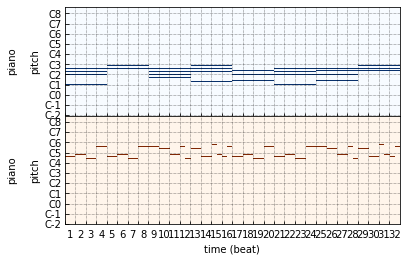

In [146]:
multitrack.plot()

In [147]:
pm = multitrack.to_pretty_midi()

In [148]:
dt_now = datetime.datetime.now()
pm.write(f'{version_num}_{dt_now.year:04d}{dt_now.month:02d}{dt_now.day:02d}_{dt_now.hour:02d}{dt_now.minute:02d}{dt_now.second:02d}.midi')

### 隔離

In [53]:
IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)

ImportError: fluidsynth() was called but pyfluidsynth is not installed.